## A simple animation first

In [138]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import Circle
from matplotlib.collections import LineCollection

In [ ]:
matplotlib.rcParams['figure.figsize'] = [25, 10]

In [ ]:
fig = plt.figure()
ax = plt.axes(xlim=(0,20), ylim=(-2,2))
line, = ax.plot([],[],lw=2)
i_text = ax.text(0.2,1.5,'');

In [ ]:
def init():
    line.set_data([], [])
    i_text.set_text('')
    return line,

def animate(i):
    x = np.linspace(0, 20, 1000)
    y = np.sin(np.pi * (0.01 * x * i))
    i_text.set_text("frame= %f" % i)
    line.set_data(x, y)
    return line, i_text

In [ ]:
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=500, interval=20)

from IPython.display import HTML
HTML(anim.to_html5_video())

anim.save("squiggly_sin_wave.mp4", fps=30)

## A simple pendulum

## The double pendulum.

### Process.

1. Take the constants and initial conditions:
    1. Initial conditions involve as angular positions and velocities: $\theta_{1}$, $\omega_{1}$, $\theta_{2}$ and $\omega_{2}$.
    1. The angular velocities correspond to angular momenta: $p_{1}$ and $p_{2}$.
    1. Constants are masses and lengths of bobs and arms: $M_{1}$, $L_{1}$, $M_{2}$ and $L_{2}$.

## A little mathematics

The equations of the double pendulum are fairly complicated to solving using "normal" classical mechanics. So, instead we use something called Lagrangian Mechanics and Hamiltonian mechanics.

When using the Lagrange method we are expected to solve, the following equation:

$$\frac{d}{dt} \frac{\partial L}{\partial \dot{x}} = \frac{\partial L}{\partial t}$$

When using L-mechanics we get two 2nd-order ODE's for $\theta_{1}$, $\theta_{2}$, $\ddot{\theta_{1}}$ and $\ddot{\theta_{2}}$. As far as my limited knowledge is concerned, we cannot directly numerically integrate 2nd-order ODE's. We'll have to convert them to four 1st-order ODEs.

Here are the two lagrangian differential equations:

1. $ {\left( {{m_1} + {m_2}} \right)l_1^2{\ddot \alpha _1} }
+ {{m_2}{l_1}{l_2}{\ddot \alpha _2}\cos \left( {{\alpha _1}  {\alpha _2}} \right) }
+ {{m_2}{l_1}{l_2}\dot \alpha _2^2\sin\left( {{\alpha _1} {\alpha _2}} \right) }
+ {\left( {{m_1} + {m_2}} \right)g{l_1}\sin {\alpha _1} }={ 0.} $

2. $ {{l_2}{\ddot \alpha _2} 
+   {l_1}{\ddot \alpha _1}\cos \left( {{\alpha _1} {\alpha _2}} \right) }
  { {l_1} \dot \alpha _1^2\sin \left( {{\alpha _1} {\alpha _2}} \right) }
+ {g\sin {\alpha _2} }={ 0.} $

In [2]:
from scipy import integrate

In [301]:
[th1, th2, p1, p2] = [180, -90, 0, 0]
(m1, l1, m2, l2, g) = 1, 1., 1, 1, 9.8
origin = (0,0)

#        [   0      1      2      3 ]
#state = [ th1,   th2,   om1,   om2 ]
state = np.radians([th1, th2, p1, p2])

dt = 0.005
t_start=0
t_end=200
t = np.arange(0.0, 200.0, dt)

In [339]:
200/0.005

40000.0

In [302]:
def deriv(state,t):
    dydx = np.zeros_like(state)
    
    th1, th2, p1, p2 = np.split(state,4,axis=0)
    
    sin_del = np.sin(th1 - th2)
    cos_del = np.cos(th1 - th2) 
    
    c1 = p1 * p2 * sin_del / (l1 * l2 * (m1 + m2 * sin_del**2 ))
    c2_num = l2**2 * m2 * p1**2 + l1**2 * ( m1 + m2 ) * p2**2 - l1 * l2 * m2 * p1 * p2 * cos_del
    c2_den = 2 *  l1**2 * l2**2 * (m1 + m2 * ( sin_del**2 ))**2
    c2 = ( c2_num / c2_den) * np.sin(2* (th1 - th2))

    dydx[0] = ( l2 * p1 - l1 * p2 * cos_del ) / ( l1**2 * l2 * ( m1 + m2 * sin_del**2 ) )
    dydx[1] = ( l1 * (m1 + m2) * p2 - l2 * m2 * p1 * cos_del ) / ( l1 * l2**2 * m2 * ( m1 + m2 * sin_del**2 ) )
    dydx[2] = -( m1 + m2) * g * l1 * np.sin(th1) - c1 + c2
    dydx[3] = -m2 * g * l2 * np.sin(th2) + c2 - c2    
    
    return dydx

In [303]:
soln = integrate.odeint(deriv, state, t)

In [317]:
x = np.cumsum( [origin[0],
                l1 * np.sin(soln[:,0]),
                l2 * np.sin(soln[:,1])] )

y = np.cumsum( [origin[1],
                -l1 * np.cos(soln[:,0]),
                -l2 * np.cos(soln[:,1])] )

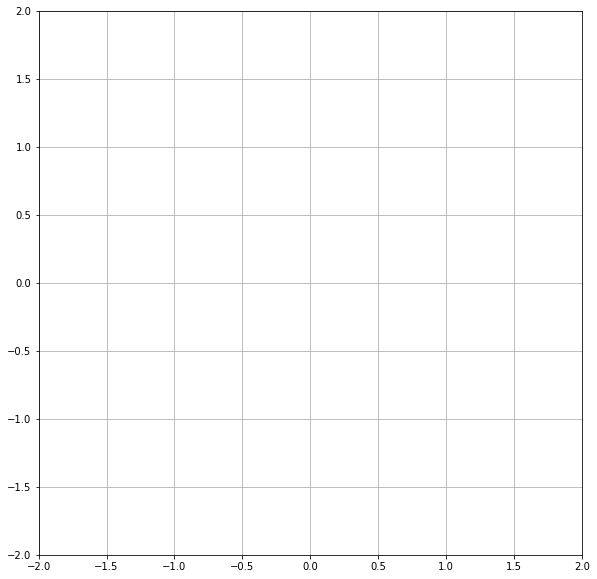

In [305]:
matplotlib.rcParams['figure.figsize'] = [10, 10]

fig = plt.figure()
ax = plt.axes(xlim=(-2,2), ylim=(-2,2), aspect='equal', autoscale_on=False)
ax.grid()

r = 0.07
c0 = Circle((x[0], y[0]), radius=r, fc='red')
c1 = Circle((x[0], y[0]), radius=r, fc='blue')
c2 = Circle((x[0], y[0]), radius=r, fc='green')

line, = ax.plot([],[],'-',lw=2, color='black')
trail2, = ax.plot([],[],'-',lw=2, color='green')

norm = plt.Normalize(0.9, 1)
colors = LineCollection([], cmap='hsv', norm=norm)
ax.add_collection(colors)

time_template = 'time = '
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes, size=20)

time_template1 = '%.1fs'
time_text1 = ax.text(0.2, 0.9, '', transform=ax.transAxes, size=20)

In [328]:
def init():
    line.set_data([],[])
#     trail1.set_data([],[])
#     trail2.set_data([],[])
    time_text.set_text(time_template)
    
    c0.center = (0,0)
    c1.center = (0,0)
    c2.center = (0,0)
    
    ax.add_patch(c0) 
    ax.add_patch(c1)
    ax.add_patch(c2)
        
    return line, time_text

def animate(i):
    x0, x1, x2 = x[0], x[1][i], x[2][i]
    y0, y1, y2 = y[0], y[1][i], y[2][i]
    
    thisx = [x0, x1, x2]
    thisy = [y0, y1, y2]
        
    c1.center = (x1, y1)
    c2.center = (x2, y2)
    
    trailx = x[2][i-100:i]
    traily = y[2][i-100:i]
    points = np.array([trailx, traily]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    colors.set_segments(segments)    
    line.set_data(thisx, thisy)
    time_text1.set_text(time_template1 % t[i])
    
    return line, colors, time_text

In [329]:
trail_duration = 5 #secs

duration = 6000/50
print("duration:",duration)

actual_fps = 6000/120
print("actual_fps:", actual_fps)

duration: 120.0
actual_fps: 50.0


In [ ]:
ani.save("double_pendulum1.mp4", fps=30)

In [ ]:
18:50
19:33